In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
from qiskit_aer.backends import AerSimulator
from qiskit_experiments.library import StateTomography


## Exercise 9


In [30]:
sim = AerSimulator()
n_shots = 500
# measure x-component
# initialize quantum state
circ = qiskit.QuantumCircuit(1,1)
circ.h(0)
circ.t(0)
# transform into x-basis and measure population
circ.h(0)
circ.measure(0,0)

result = sim.run(circ, shots=n_shots).result()
counts = result.get_counts(circ)
c_x = 2*(counts['0']/n_shots) - 1

0.6359999999999999

In [ ]:
# measure y-component
# initialze quantum state
circ = qiskit.QuantumCircuit(1,1)
circ.h(0)
circ.t(0)
# transform into y-basis and measure population
circ.sdg(0)
circ.h(0)
circ.measure(0,0)
result = sim.run(circ, shots = n_shots).result()
counts = result.get_counts(circ)
c_y = 2*(counts['0']/n_shots) -1

0.6319999999999999

In [33]:
# measure z-component
# initialize quantum state
circ = qiskit.QuantumCircuit(1,1)
circ.h(0)
circ.t(0)
# measure population
circ.measure(0,0)
result = sim.run(circ,shots=n_shots).result()
counts = result.get_counts(circ)
c_z = 2*(counts['0']/n_shots) -1

-0.04800000000000004

In [8]:
# define Pauli matrices
import qiskit.quantum_info

identity = qiskit.quantum_info.Pauli('I').to_matrix()
sigma_x = qiskit.quantum_info.Pauli('X').to_matrix()
sigma_y = qiskit.quantum_info.Pauli('Y').to_matrix()
sigma_z = qiskit.quantum_info.Pauli('Z').to_matrix()

In [34]:
# construct density matrix
rho = 1/2*(1*identity + c_x*sigma_x + c_y*sigma_y + c_z*sigma_z)
# initialize quantum circuit
circ = qiskit. QuantumCircuit(1)
circ.h(0)
circ.t(0)
# use StateTomography method to reconstruct quantum state
tomo = StateTomography(circ)
tomodata = tomo.run(sim).block_for_results()
tomoresult = tomodata.analysis_results('state').value
# define the exact solution
circ = qiskit.QuantumCircuit(1,1)
circ.h(0)
circ.t(0)
circ.save_statevector()
exactstate = sim.run(circ).result().get_statevector()

In [35]:
# calculate the fidelities
qiskit.quantum_info.state_fidelity(rho, exactstate)
qiskit.quantum_info.state_fidelity(tomoresult, exactstate)

0.9483056992722712

## Exercise 10

In [37]:
# implement theoretical expectations
def alpha_theo(t,w,w0,w1):
    delta = w - w0
    omega = np.sqrt(w1**2 + delta**2)
    return np.sqrt(np.cos(omega*t/2)**2 + (delta/omega)**2 * np.sin(omega*t/2)**2)

def beta_theo(t,w,w0,w1):
    delta = w -w0
    omega = np.sqrt(w1**2 + delta**2)
    return 1j * np.exp(-1j*w*t)*(-1j*w1/(2*omega) * np.sin(omega*t)+(w1*delta)/omega**2 * np.sin(omega*t/2)**2)/    (np.sqrt(np.cos(omega*t/2)**2+(delta/omega)**2 * np.sin(omega*t/2)**2))

def time_evolve(circ, t, dt, w, w0, w1):
    N = int(t/dt)
    # apply gates for every timestep seperately
    for i in range(N):
        circ.rz(-w0*dt, range(circ.num_qubits))
        circ.rx(2*w1*dt*np.cos(i*w*dt), range(circ.num_qubits))

In [38]:
# use parameters from exercise 5a
w1a = 2
w0a = 25
wa = 25.5
dt = 0.05
ta = np.linspace(0,4,800)
# create arrays for results
alpha = []
beta = []
n_shots = 500
sim = AerSimulator()
for i in range(len(ta)):
    qchannel = qiskit.QuantumRegister(1)
    cchannel = qiskit.ClassicalRegister(1)
    rabi = qiskit.QuantumCircuit(qchannel,cchannel)
    #apply time evolution
    time_evolve(rabi,ta[i],dt,wa,w0a,w1a)
    # perform State Tomography
    coeff = StateTomography(rabi)
    coeff.set_run_options(shots = n_shots)
    coeff_data = coeff.run(sim).block_for_results()
    coeff_result = coeff_data.analysis_results('state').value
    # extract coefficients
    a = np.sqrt(np.array(coeff_result)[0,0])
    b = np.array(coeff_result)[1,0]/a
    alpha.append(a)
    beta.append(b)

In [45]:
alphat = alpha_theo(ta,25.5,25,2)

c:\Users\Nutzer 1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


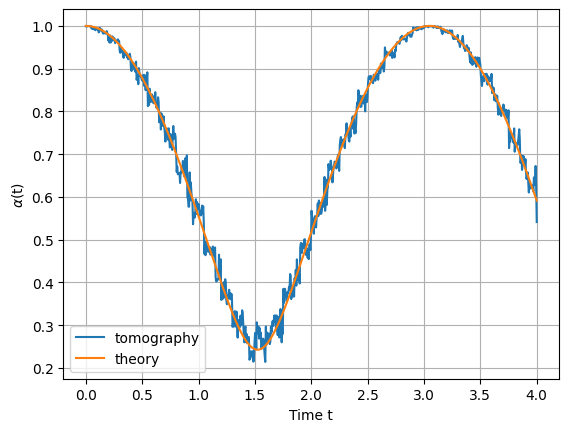

In [61]:
plt.plot(ta, alpha, label='tomography')
plt.plot(ta, alphat, label='theory')
plt.xlabel('Time t')
plt.ylabel(r'$\alpha$(t)')
plt.legend()
plt.grid()
plt.savefig('alpha')

In [51]:
betat = beta_theo(ta,25.5,25,2)

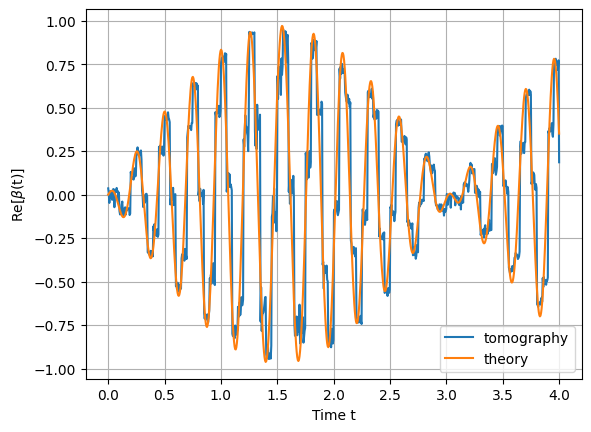

In [62]:
plt.plot(ta, np.real(beta), label='tomography')
plt.plot(ta, np.real(betat), label='theory')
plt.xlabel('Time t')
plt.ylabel(r'Re[$\beta$(t)]')
plt.legend()
plt.grid()
plt.savefig('beta_real')

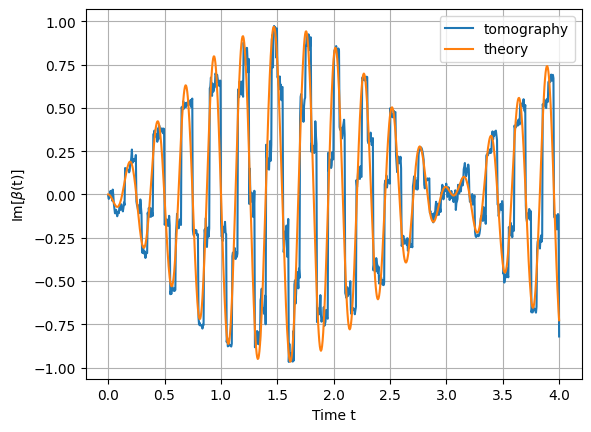

In [63]:
plt.plot(ta, np.imag(beta), label='tomography')
plt.plot(ta, np.imag(betat), label='theory')
plt.xlabel('Time t')
plt.ylabel(r'Im[$\beta$(t)]')
plt.legend()
plt.grid()
plt.savefig('beta_imag')